<a href="https://colab.research.google.com/github/Shubhamd13/NLP/blob/main/9_1_ViT_CLIP_Student_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 01: Vision Transformer (ViT)

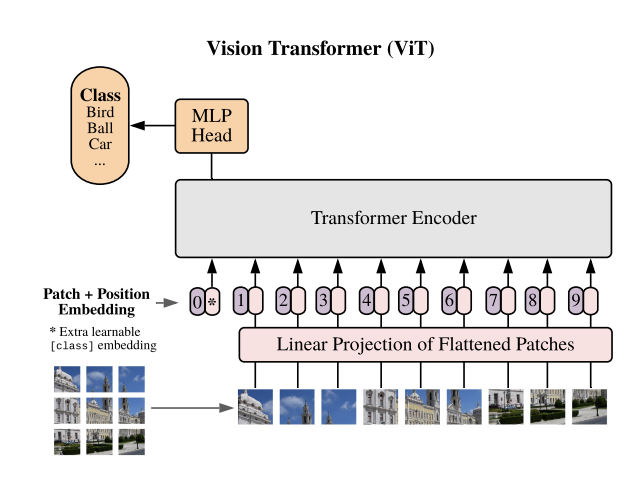

### Utility

In [9]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

def display_patches(patches, patch_size, channels=3, max_patches=300):
    num_patches = min(len(patches), max_patches)
    patches = patches[:num_patches]

    grid_size = int(np.ceil(np.sqrt(num_patches)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(num_patches):
        patch = patches[i].reshape(patch_size, patch_size, channels)

        # Normalize if float
        if np.issubdtype(patch.dtype, np.floating):
            patch_min, patch_max = patch.min(), patch.max()
            if patch_max > patch_min:
                patch = (patch - patch_min) / (patch_max - patch_min)  # normalize to 0-1
            patch = (patch * 255).astype(np.uint8)

        if channels == 1:
            patch = patch.squeeze(-1)
            axes[i].imshow(patch, cmap='gray')
        else:
            axes[i].imshow(patch)

        axes[i].axis('off')

    for j in range(num_patches, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### Setup

In [10]:
image_size = 256
patch_size = 32

embed_dim = 64

SEED = 42

### Step 1: Load Image

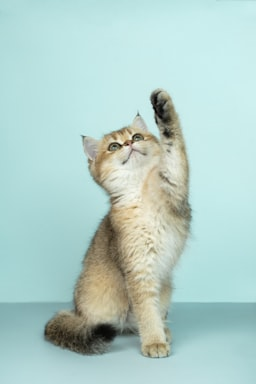

Original Shape:  (384, 256, 3)
Resized Shape:  (256, 256, 3)


In [11]:
np.random.seed(SEED)

# Load Image
url = "https://images.unsplash.com/photo-1592194996308-7b43878e84a6?ixlib=rb-4.0.3&auto=format&fit=crop&w=256&q=80"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

display(img)
print("Original Shape: ", np.array(img).shape)

# Resize Image
img = img.resize((image_size, image_size))
print("Resized Shape: ", np.array(img).shape)
image = np.array(img) / 255.0  # Normalize

### Step 2: Create Patches

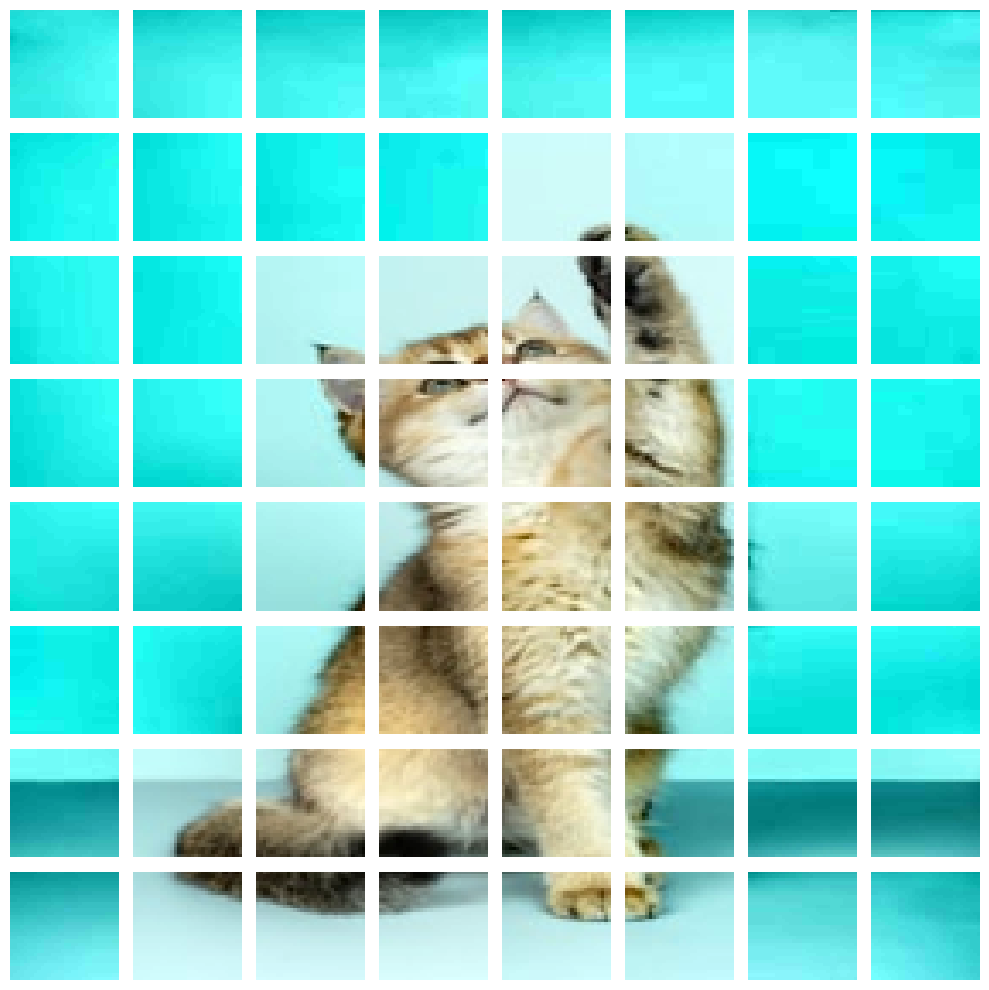

In [12]:
# Create Image Patches
def get_patches(image, patch_size):
    patches = []
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch.reshape(-1))  # flatten each patch
    return np.array(patches)

# Get Patches
patches = get_patches(image, patch_size)

# Show Patches
display_patches(patches, patch_size, channels=image.shape[2])

### Step 3: Define Class Categories and Patch Embedding



In [13]:
# Define Class Labels
class_names = ["dog", "cat", "car", "plane", "truck", "bird", "boat", "horse", "sheep", "person"]
num_classes = len(class_names)

# Patch embedding
patch_dim = patch_size * patch_size * 3  # RGB

np.random.seed(SEED)
W_patch = np.random.randn(patch_dim, embed_dim) * 0.01
embedded_patches = patches @ W_patch

np.random.seed(SEED)
cls_token = np.random.randn(1, embed_dim) * 0.01
image_patch_embeds = np.vstack([cls_token, embedded_patches])  # [CLS] + patch embedding

### Step 4: Transformer Encoder

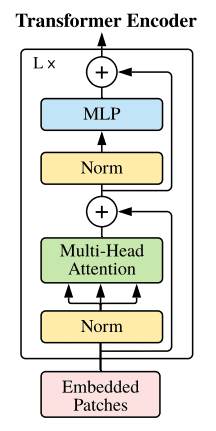


$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$


In [14]:
# Layer Normaliztion
def layer_norm(x, eps=1e-6):
    mean = x.mean(-1, keepdims=True)
    std = x.std(-1, keepdims=True)
    return (x - mean) / (std + eps)

# Self-attention
def self_attention(x, SEED):
    np.random.seed(SEED)
    W_Q = np.random.randn(embed_dim, embed_dim) * 0.01
    W_K = np.random.randn(embed_dim, embed_dim) * 0.01
    W_V = np.random.randn(embed_dim, embed_dim) * 0.01

    Q = x @ W_Q
    K = x @ W_K
    V = x @ W_V

    ###<--- Write code here
    scores =   (Q @ K.T) / np.sqrt(embed_dim)                   # QK^T/sqrt(d)
    ###

    weights = np.exp(scores - np.max(scores, axis=-1, keepdims=True))
    weights /= weights.sum(axis=-1, keepdims=True)

    output = weights @ V
    return output, weights

# MLP layers
mlp_hidden_dim = 128

def mlp(x, SEED):
    np.random.seed(SEED)

    W_mlp1 = np.random.randn(embed_dim, mlp_hidden_dim) * 0.01
    b_mlp1 = np.random.randn(mlp_hidden_dim) * 0.01
    W_mlp2 = np.random.randn(mlp_hidden_dim, embed_dim) * 0.01
    b_mlp2 = np.random.randn(embed_dim) * 0.01

    x = x @ W_mlp1 + b_mlp1
    x = np.maximum(0, x)
    return x @ W_mlp2 + b_mlp2

# Transformer encoder forward
def encoder_forward(x, SEED):
  x_norm = layer_norm(x)                                        # layer normalization
  attn_out, attn_weights = self_attention(x_norm, SEED)         # self attention
  x = x + attn_out                                              # residual connection
  x = x + mlp(layer_norm(x), SEED)                              # rest of the architecture
  return x

# Call encoder with image patch embeddings
encoder_output = encoder_forward(image_patch_embeds, SEED)

### Step 5: MLP Head for classification

In [15]:
np.random.seed(SEED)

# Probability Calculation
cls_output = encoder_output[0]
W_cls = np.random.randn(embed_dim, num_classes)
b_cls = np.random.randn(num_classes)

###<--- Write code here
logits =     cls_output @ W_cls + b_cls                    # Compute XW + b
###


probs = np.exp(logits - np.max(logits))
probs /= probs.sum()

# Class Prediction
predicted_idx = np.argmax(probs)
predicted_class = class_names[predicted_idx]

print("Class probabilities:")
for i, cls in enumerate(class_names):
    print(f"  {cls:8}: {probs[i]:.4f}")
print(f"\nPredicted class: {predicted_class}")

Class probabilities:
  dog     : 0.1190
  cat     : 0.3063
  car     : 0.0670
  plane   : 0.0031
  truck   : 0.1605
  bird    : 0.2121
  boat    : 0.0017
  horse   : 0.0579
  sheep   : 0.0165
  person  : 0.0559

Predicted class: cat


# Part 02: CLIP

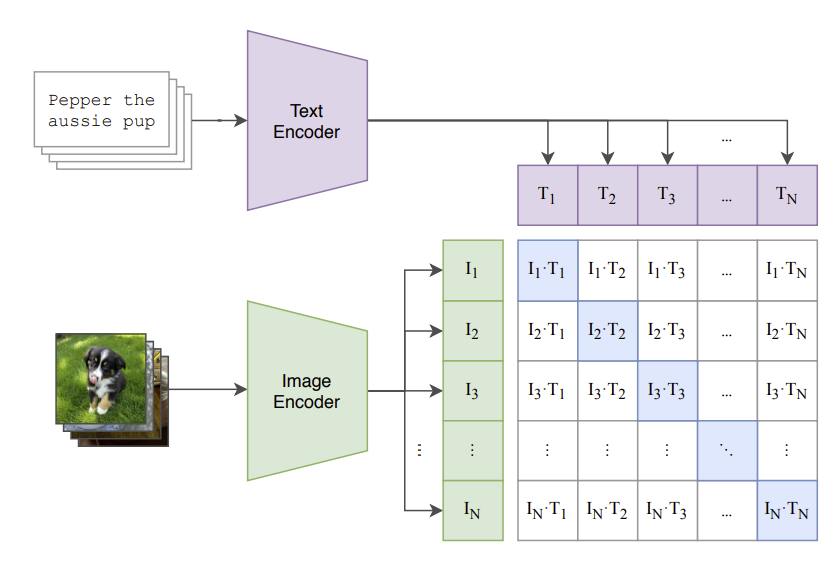

### Utility

In [16]:
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import re

### Setup

In [17]:
TXT_SEED = 666
IMG_SEED = 42

image_size = 64
img_patch_size = 8

max_text_len = 16
embed_dim = 64

### Step 1: Image and Text input

In [18]:
# for simplicity, we take two image-text pairs

def download_image(url, size=(64, 64)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img = img.resize(size)
    return np.array(img) / 255.0

urls = [
    "https://images.unsplash.com/photo-1518717758536-85ae29035b6d?ixlib=rb-4.0.3&auto=format&fit=crop&w=256&q=80",  # dog
    "https://images.unsplash.com/photo-1506744038136-46273834b3fb?ixlib=rb-4.0.3&auto=format&fit=crop&w=256&q=80",  # cat
]

# load image
images = [download_image(url, (image_size, image_size)) for url in urls]

# corresponding texts
texts = [
    "a photo of a dog",
    "a picture of a cat",
]

### Step 2: Text Encoding

The text encoder maps
text captions T_1, T_2,
..., T_N to embedding vectors.

In [19]:
# Vocabulary Construction
def tokenize(text):
    return re.findall(r'\w+', text.lower())

def build_vocab(texts):
    vocab = {}
    idx = 0
    for text in texts:
        for token in tokenize(text):
            if token not in vocab:
                vocab[token] = idx
                idx += 1
    return vocab

vocab = build_vocab(texts)
vocab_size = len(vocab)
print("Vocabulary: ", vocab)


# Text Embedding
np.random.seed(TXT_SEED)
W_token = np.random.randn(vocab_size, embed_dim) * 0.01
cls_token_txt = np.random.randn(1, embed_dim) * 0.01

text_reps = []
for txt in texts:
    tokens = tokenize(txt)
    token_ids = [vocab.get(t, 0) for t in tokens][:max_text_len]

    # initial text token embeddings
    token_embeds = np.zeros((max_text_len, embed_dim))
    for i, tid in enumerate(token_ids):
        token_embeds[i] = W_token[tid]
    tokens = np.vstack([cls_token_txt, token_embeds])  # [CLS] + text token embeddings

    # Call Transformer Encoder defined in Part 01, Step 4 with a different seed value
    x = encoder_forward(tokens, TXT_SEED)

    # Consider class embedding as the whole text representation
    cls_embed = x[0] / np.linalg.norm(x[0])
    text_reps.append(cls_embed)

text_embedding = np.array(text_reps)
print("\nText Embedding:\n", text_embedding)

Vocabulary:  {'a': 0, 'photo': 1, 'of': 2, 'dog': 3, 'picture': 4, 'cat': 5}

Text Embedding:
 [[ 1.67899666e-02  1.52573842e-01 -4.57268978e-02  1.06004860e-01
  -1.22376440e-01 -2.41788793e-01  9.46802151e-03 -8.41754805e-02
  -8.23464114e-02  2.02692759e-02 -3.42598737e-02  1.18691211e-01
   2.36637456e-01 -8.08045112e-02  1.85861513e-01 -5.91828263e-02
  -7.81346700e-02 -3.87103970e-02 -1.06017319e-01  1.71072038e-01
  -1.96374492e-02 -1.20215959e-01 -3.71742971e-02  8.77415828e-03
  -4.82979813e-03 -1.00573067e-02  4.90756387e-02 -3.40517725e-04
   1.28116686e-02 -7.24061388e-02 -4.88114489e-02 -2.10738000e-01
  -7.91489116e-02 -9.12635265e-02 -4.90506751e-02  5.56801663e-02
   2.52645357e-01 -1.54355735e-01 -1.25235831e-01 -1.04188007e-02
  -1.80987938e-01  4.71147300e-02 -1.29939293e-01  3.59315643e-02
  -1.33374063e-01 -7.50327964e-02 -1.62291494e-01  3.55703834e-01
  -7.78998633e-02 -7.77037099e-02  7.97702992e-02 -2.23033261e-03
  -2.57586791e-01 -5.49664337e-02 -1.95953875e-

### Step 3: Image Encoding

The image encoder
maps images I_1, I_2,
..., I_N to embedding vectors.

In [20]:
# Get patches
def patchify(image, patch_size):
    H, W, C = image.shape
    patches = []
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            patches.append(patch.reshape(-1))
    return np.array(patches)

# Patch Embedding
np.random.seed(IMG_SEED)
img_patch_dim = img_patch_size * img_patch_size * 3
W_patch = np.random.randn(img_patch_dim, embed_dim) * 0.01
cls_token_img = np.random.randn(1, embed_dim) * 0.01


image_reps = []
for img in images:
    # get image patches
    patches = patchify(img, img_patch_size)
    print(len(patches))

    # compute patch embedding
    patch_embeds = patches @ W_patch

    tokens = np.vstack([cls_token_img, patch_embeds])  # [CLS] + patch embedding

    # call Transformer Encoder defined in Part 01, Step 4 with a different seed value
    x = encoder_forward(tokens, IMG_SEED)

    # consider class embedding as the whole image representation
    cls_embed = x[0] / np.linalg.norm(x[0])
    image_reps.append(cls_embed)

image_embedding = np.array(image_reps)
print("Image Embedding:\n", image_embedding)

64
64
Image Embedding:
 [[-0.03496202  0.0059526  -0.08563411 -0.13632783  0.0344666   0.19654835
   0.01450421  0.28012145  0.06255646 -0.07693595 -0.15027516  0.05608019
   0.02306003 -0.1271498   0.06109875  0.08819226 -0.1888913  -0.12706718
   0.04102495  0.2289812  -0.07248573  0.2992713  -0.01573815 -0.20782386
   0.06839331  0.00092754 -0.09521541  0.21229781  0.175824   -0.01088309
  -0.22485304  0.02005031  0.08010838  0.2221984  -0.18249654 -0.04097307
  -0.07810594  0.24648138 -0.03417986 -0.09002653 -0.04028468  0.08876377
   0.16701683 -0.21572408 -0.0038879  -0.08730975 -0.05356486 -0.05726837
  -0.09187954  0.13112375 -0.03819233  0.02693668 -0.12681503 -0.09755401
   0.0415526  -0.11496165  0.13223459 -0.11374873  0.11487009  0.05890964
  -0.08676177  0.11981622 -0.02951388 -0.05219618]
 [-0.03163084  0.03440083 -0.10057107 -0.14120417  0.01654712  0.16892423
   0.01291374  0.2523183   0.03885507 -0.05693271 -0.11690641  0.06452697
   0.00928152 -0.12359259  0.10989205

### Step 4: Similarity Matrix

A matrix of dot products
between all image-text pairs
is computed.

In [21]:
###<--- Write code here
similarity =   image_embedding @ text_embedding.T                  # compute img embedding x text embedding^T
###


print("Similarity Matrix:\n", similarity)

print("\nSimilarity matrix (image x text):")
for i in range(len(images)):
    for j in range(len(texts)):
        print(f"Image {i+1} and Text '{texts[j]}': {similarity[i,j]:.4f}")

Similarity Matrix:
 [[-0.09533079 -0.05735082]
 [-0.07268116 -0.02693789]]

Similarity matrix (image x text):
Image 1 and Text 'a photo of a dog': -0.0953
Image 1 and Text 'a picture of a cat': -0.0574
Image 2 and Text 'a photo of a dog': -0.0727
Image 2 and Text 'a picture of a cat': -0.0269


### Step 5: Contrastive Loss

The model is trained to
maximize similarity for
correct pairs and minimize
for incorrect ones. This is often done with a
cross-entropy loss over
the similarity scores (like a
softmax over rows and
columns).

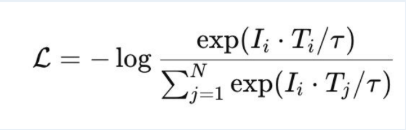

In [22]:
# Softmax
def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

# InfoNCE loss
def info_nce_loss(similarity_matrix, temperature=0.07):
    logits = similarity_matrix / temperature
    labels = np.arange(len(logits))

    # Image-to-Text
    probs_i2t = softmax(logits, axis=1)
    loss_i2t = -np.log(probs_i2t[np.arange(len(labels)), labels]).mean()

    # Text-to-Image
    probs_t2i = softmax(logits.T, axis=1)

    ###<--- Write code here
    loss_t2i = -np.log(probs_t2i[np.arange(len(labels)), labels]).mean()                      # similar to the loss calculation of image-to-text
    ####

    return (loss_i2t + loss_t2i) / 2

loss = info_nce_loss(similarity)
print("Contrastive loss:", loss)

Contrastive loss: 0.6967343429791324
